## Import Libraries

In [1]:
from osgeo import gdal
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import cv2
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Open Files

https://www.earthdatascience.org/tutorials/visualize-digital-elevation-model-contours-matplotlib/

In [2]:
filename = "AletschGlacierDEM.tiff"
gdata = gdal.Open(filename)

In [3]:
gdata.GetGeoTransform()

(637342.9875465514,
 24.999899583000516,
 0.0,
 154037.85892408466,
 0.0,
 -24.999899583000516)

In [4]:
# dir(gdata)

## Gdal Raster Processing

In [5]:
gdal_band = gdata.GetRasterBand(1)
nodataval = gdal_band.GetNoDataValue()

In [7]:
g = gdata.ReadAsArray()
print(g.dtype)
g = g.astype('float64')
print(g.dtype)

int16
float64


In [8]:
# replace missing values if necessary
if np.any(g == nodataval):
    g[g == nodataval] = np.nan

In [9]:
print(gdata.RasterXSize, gdata.RasterYSize)

693 720


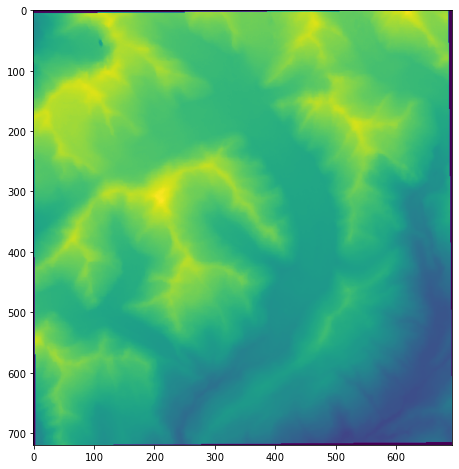

In [10]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.imshow(g)
# cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
# plt.gca().invert_yaxis()
plt.show()

In [11]:
# #Plot our data with Matplotlib's 'contourf'
# fig = plt.figure(figsize = (12, 8))
# ax = fig.add_subplot(111)
# plt.contourf(g, 
#             levels = list(range(0, int(g.max()), 50)))  #cmap = "gray", 
# cbar = plt.colorbar()
# plt.gca().set_aspect('equal', adjustable='box')
# # plt.gca().invert_yaxis()
# plt.show()

In [12]:
gt = gdata.GetGeoTransform()
gt

(637342.9875465514,
 24.999899583000516,
 0.0,
 154037.85892408466,
 0.0,
 -24.999899583000516)

In [13]:
g.min()

0.0

## Point Cloud Generation

In [14]:
print(g.shape)

GTransf = gdata.GetGeoTransform()
GTransf

(720, 693)


(637342.9875465514,
 24.999899583000516,
 0.0,
 154037.85892408466,
 0.0,
 -24.999899583000516)

In [15]:
# points = []

# for j_vertical in range(g.shape[0]):
#     for i_horizental in range(g.shape[1]):
        
#         x= (i_horizental)*GTransf[1] + (j_vertical)*GTransf[2] + GTransf[0]
#         y= (i_horizental)*GTransf[4] + (j_vertical)*GTransf[5] + GTransf[3]
#         z= g[j_vertical,i_horizental]
#         points.append([x,y,z])
# points = np.array(points) 

# np.savetxt('Mountain_PointCloud_no_deletion.out', points, delimiter=',')

In [16]:
points = np.loadtxt('Mountain_PointCloud_no_deletion.out', delimiter=',')

In [17]:
points.shape

(498960, 3)

In [18]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
o3d.visualization.draw_geometries([pcd])

In [19]:
def Custom_Visualizer_Mesh(obj):
    width=1820
    vis = o3d.visualization.Visualizer()
    vis.create_window('Open3D', width, height=980,
                      left=int(0.5*(1920-width)), top=35, visible=True)
    vis.add_geometry(obj)

    RenderOpt = vis.get_render_option()
    RenderOpt.show_coordinate_frame= True
    RenderOpt.mesh_show_wireframe = True
    vis.run()
    vis.destroy_window()

In [20]:
Custom_Visualizer_Mesh(pcd)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


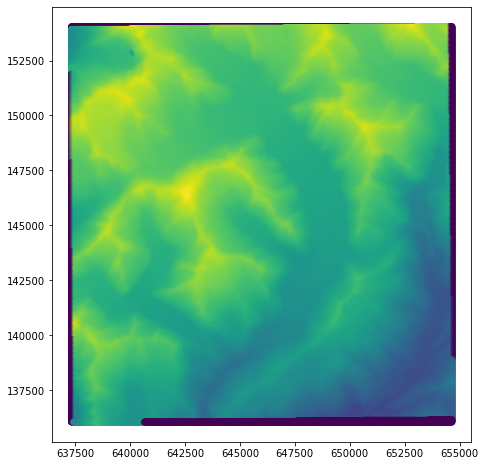

In [29]:
fig = plt.figure(figsize = (12, 8))
plt.scatter(points[:,0],points[:,1], c=points[:,2])
plt.axis('scaled')
plt.show()

In [22]:
print(points[:,0].min())
print(points[:,0].max())
print(points[:,0].max()-points[:,0].min())
print('-------------------------------------')
print(points[:,1].min())
print(points[:,1].max())
print(points[:,1].max()-points[:,1].min())

637342.9875465514
654642.9180579877
17299.93051143631
-------------------------------------
136062.9311239073
154037.85892408466
17974.927800177364


In [23]:
print(points[points[:,2]!=0][:,0].min())
print(points[points[:,2]!=0][:,0].max())
print(points[points[:,2]!=0][:,0].max()-points[points[:,2]!=0][:,0].min())
print('-------------------------------------')
print(points[points[:,2]!=0][:,1].min())
print(points[points[:,2]!=0][:,1].max())
print(points[points[:,2]!=0][:,1].max()-points[points[:,2]!=0][:,1].min())
print('-------------------------------------')
print(points[points[:,2]!=0][:,2].min())
print(points[points[:,2]!=0][:,2].max())
print(points[points[:,2]!=0][:,2].max()-points[points[:,2]!=0][:,2].min())

637342.9875465514
654642.9180579877
17299.93051143631
-------------------------------------
136062.9311239073
154037.85892408466
17974.927800177364
-------------------------------------
854.0
4152.0
3298.0


### Working With NP.Array

In [318]:
data_array = g

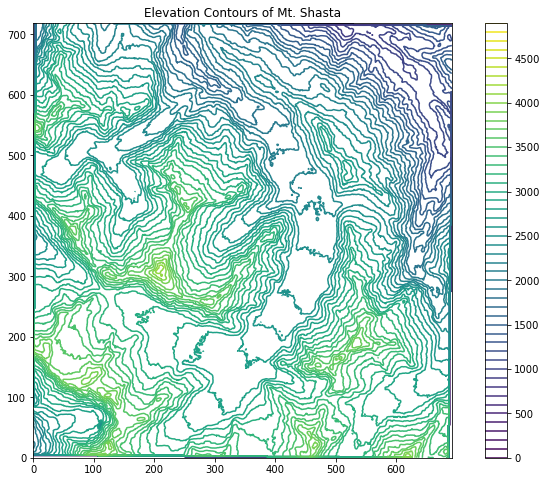

In [319]:
#Plot out data with Matplotlib's 'contour'
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contour(data_array, cmap = "viridis", 
            levels = list(range(0, 5000, 100)))
plt.title("Elevation Contours of Mt. Shasta")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [320]:
data_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

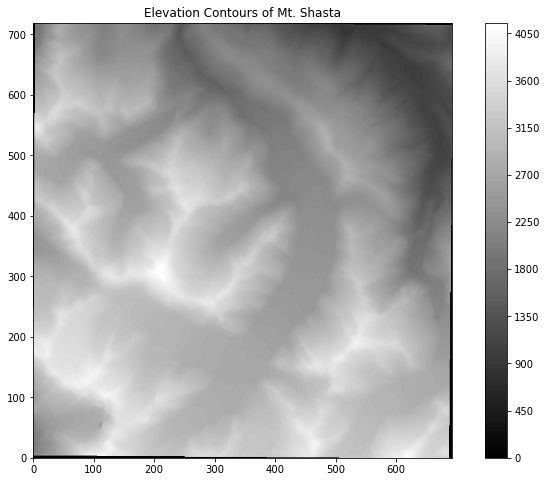

In [321]:
#Plot our data with Matplotlib's 'contourf'
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(data_array, cmap = "gray", 
            levels = list(range(0, int(data_array.max()), 50)))
plt.title("Elevation Contours of Mt. Shasta")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

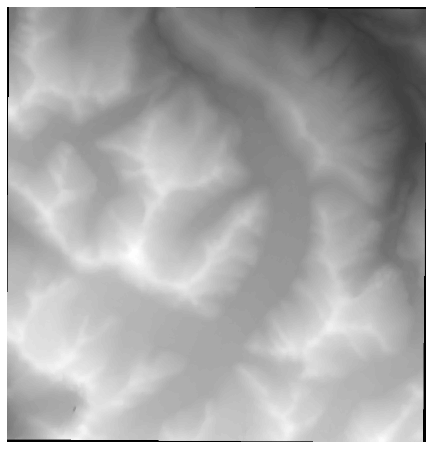

In [322]:
#Plot our data with Matplotlib's 'contourf'
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
plt.contourf(data_array, cmap = "gray", 
            levels = list(range(0, int(data_array.max()), 50)))
# plt.title("Elevation Contours of Mt. Shasta")
# cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()

## Convert to Image

In [24]:
Image = ((g/g.max())*255).astype('uint8')

In [25]:
# cv2.imwrite('DEM_Image_Gray_No_deletion.jpg', Image)

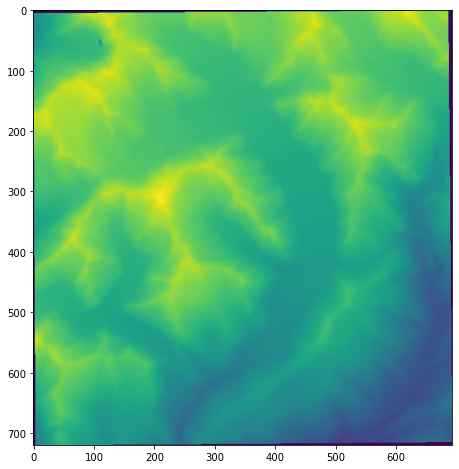

In [26]:
fig = plt.figure(figsize = (12, 8))
plt.imshow(Image) #cmap='gray'

## Keypoints Detection from Image

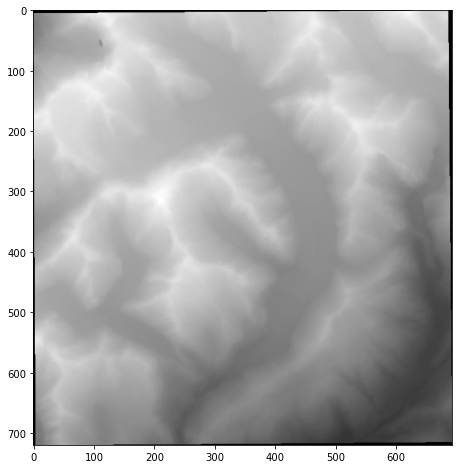

In [27]:
gray_image = cv2.imread('DEM_Image_Gray_No_deletion.jpg', cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize = (12, 8))
plt.imshow(gray_image, cmap='gray') 

In [28]:
print(gray_image.dtype)
print(gray_image.max())
print(gray_image.shape)

uint8
255
(720, 693)


In [29]:
gray_image

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### SIFT

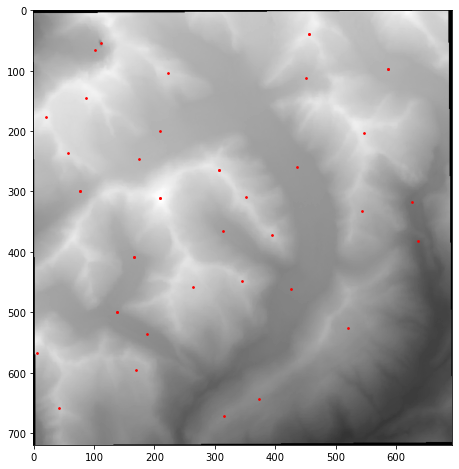

In [31]:
# default: 
# sift=cv2.xfeatures2d.SIFT_create(nfeatures = 0, nOctaveLayers = 3, contrastThreshold = 0.04,
#                                    edgeThreshold = 10, sigma = 1.6)

sift = cv2.xfeatures2d.SIFT_create(nfeatures = 0, nOctaveLayers = 3, contrastThreshold = 0.03,
                                  edgeThreshold = 10, sigma = 1.6)
sift_keypoints, sift_descriptors = sift.detectAndCompute(gray_image,None)

if len(sift_keypoints)==0: print("no keypoints found")
else:
    sift_kp = np.array([i.pt for i in sift_keypoints])

    fig = plt.figure(figsize = (12, 8))
    plt.imshow(Image, cmap='gray')
    plt.scatter(sift_kp[:,0],sift_kp[:,1], c='red', s=3)
    #plt.title('Number of Keypoints = '+ str(len(sift_keypoints)))
    plt.show()

In [ ]:
# kp_img = cv2.drawKeypoints(Image, keypoints_1, None, color=(0, 0, 255), flags=0)

# fig= plt.figure(figsize=(12,8))
# imgplot = plt.imshow(kp_img[:,:,::-1])

In [ ]:
# fig, ax= plt.subplots(1,2, figsize=(12,6))
# # plt.subplots_adjust(wspace=-0.4, hspace=0)

# ax[0].imshow(Image, cmap='gray')
# ax[0].invert_yaxis()

# ax[1].imshow(Image, cmap='gray')
# ax[1].scatter(kp[:,0],kp[:,1], c='red', s=3)
# ax[1].invert_yaxis()

In [ ]:
# np.savetxt('2D_SIFT_DEM_Keypoints.out', sift_kp, delimiter=',')

### Harris

In [ ]:
# default: 
# sift=cv2.xfeatures2d.SIFT_create(nfeatures = 0, nOctaveLayers = 3, contrastThreshold = 0.04,
#                                    edgeThreshold = 10, sigma = 1.6)

gray_image_harris = np.copy(gray_image).astype(np.float32)

dst = cv2.cornerHarris(gray_image_harris, blockSize=3, ksize=3, k=0.04)

# dilate to mark the corners
dst = cv2.dilate(dst, None)
gray_image_harris[dst > 0.0008 * dst.max()]=0

harris_kp = np.argwhere(gray_image_harris==0)

fig = plt.figure(figsize = (12, 8))
plt.imshow(gray_image_harris, cmap='gray')
plt.scatter(harris_kp[:,1],harris_kp[:,0], c='red', s=0.1)
plt.title('Number of Keypoints = '+ str(harris_kp.shape[0]))
plt.show()

In [ ]:
fig, ax= plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(gray_image, cmap='gray')
ax[1].imshow(gray_image_harris, cmap='gray');

### Shi-Tomasi

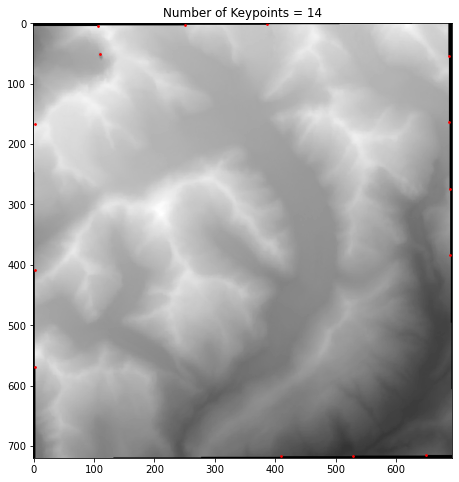

In [33]:
Shi_Tomasi_kp = cv2.goodFeaturesToTrack(gray_image, maxCorners=90,
                                  qualityLevel=0.01, minDistance=20)
Shi_Tomasi_kp = np.float32(Shi_Tomasi_kp).squeeze(1)


fig = plt.figure(figsize = (12, 8))
plt.imshow(gray_image, cmap='gray')
plt.scatter(Shi_Tomasi_kp[:,0],Shi_Tomasi_kp[:,1], c='red', s=3)
plt.title('Number of Keypoints = '+ str(Shi_Tomasi_kp.shape[0]))
plt.show()

### SURF (Speeded-Up Robust Features)

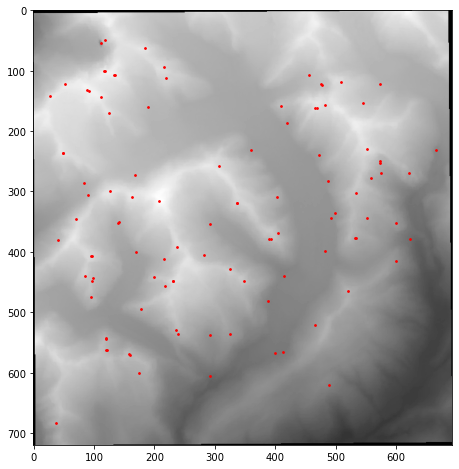

In [38]:
surf = cv2.xfeatures2d.SURF_create(hessianThreshold = 90, nOctaves = 4, nOctaveLayers = 3)
surf_keypoints, surf_des = surf.detectAndCompute(gray_image, None)

if len(surf_keypoints)==0: print("no keypoint found")

else:
    surf_kp = np.array([i.pt for i in surf_keypoints])

    fig = plt.figure(figsize = (12, 8))
    plt.imshow(gray_image, cmap='gray')
    plt.scatter(surf_kp[:,0],surf_kp[:,1], c='red', s=3)
    
    #plt.title('Number of Keypoints = '+ str(surf_kp.shape[0]))
    plt.show()

### ORB

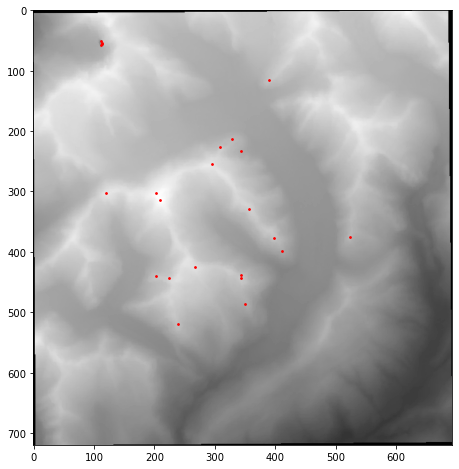

In [39]:
orb = cv2.ORB_create(nfeatures = 1000, scaleFactor = 1.9, nlevels = 8, edgeThreshold = 31,
                     firstLevel = 0, WTA_K = 4, scoreType = 0 , patchSize = 31,
                     fastThreshold = 10 )

orb_keypoints, orb_des = orb.detectAndCompute(gray_image, None)

if len(orb_keypoints)==0: print("no keypoint founded")
else:
    orb_kp = np.array([i.pt for i in orb_keypoints])

    fig = plt.figure(figsize = (12, 8))
    plt.imshow(gray_image, cmap='gray')
    plt.scatter(orb_kp[:,0],orb_kp[:,1], c='red', s=3)
#     plt.gca().invert_yaxis() ######################################
#     plt.gca().invert_xaxis()
    #plt.title('Number of Keypoints = '+ str(orb_kp.shape[0]))
    
    
#     for i in range(orb_kp.shape[0]):
#         margin = orb_kp[i,0]*0.05
#         plt.text(orb_kp[i,0]+margin, orb_kp[i,1], str(i),
#                 horizontalalignment='left', size='large', color='blue', weight='semibold')
    
#     plt.grid()
    plt.show()

In [49]:
# np.savetxt('DEM_Raster_keypoint.out', orb_kp, delimiter=',')

## Extracting GeoPoints from Keypoints

In [57]:
np.unravel_index(np.argmax(g, axis=None), g.shape)

(314, 212)

In [59]:
orb_kp.round(0).astype('int64')[6]

array([202, 303], dtype=int64)

In [52]:
print(g[303,202])
print(g[202,303])

4031.0
2775.0


In [60]:
def ImgKeyPoints_To_GeoKeyPoints(ImgKeyPoints, DEM_DataArray, GDAL_GeoTransform):
    
    ImgKeyPoints_indices = ImgKeyPoints.round(0).astype('int64')
    
    GeoKeyPoints = []
    for i_horizental,j_vertical in ImgKeyPoints_indices:
        
        x= (i_horizental)*GTransf[1] + (j_vertical)*GTransf[2] + GTransf[0]
        y= (i_horizental)*GTransf[4] + (j_vertical)*GTransf[5] + GTransf[3]
        z= DEM_DataArray[j_vertical,i_horizental]
        
        GeoKeyPoints.append([x,y,z])
    GeoKeyPoints = np.array(GeoKeyPoints)
    return GeoKeyPoints

In [61]:
Geo_Keypoints = ImgKeyPoints_To_GeoKeyPoints(orb_kp, g, GTransf)

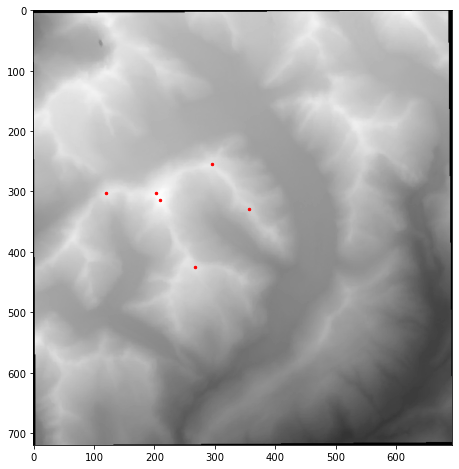

In [62]:
orb = cv2.ORB_create(nfeatures = 1000, scaleFactor = 1.9, nlevels = 8, edgeThreshold = 31,
                     firstLevel = 0, WTA_K = 4, scoreType = 0 , patchSize = 31,
                     fastThreshold = 10 )

orb_keypoints, orb_des = orb.detectAndCompute(gray_image, None)

highestElev_index = np.argsort(-Geo_Keypoints[:,2])[0:6]

if len(orb_keypoints)==0: print("no keypoint founded")
else:
    orb_kp = np.array([i.pt for i in orb_keypoints])

    fig = plt.figure(figsize = (12, 8))
    plt.imshow(gray_image, cmap='gray')
    plt.scatter(orb_kp[highestElev_index][:,0],orb_kp[highestElev_index][:,1], c='red', s=6)
#     plt.gca().invert_yaxis() ######################################
#     plt.gca().invert_xaxis()
#     plt.title('Number of Keypoints = '+ str(orb_kp.shape[0]))
    
    
#     for i in range(orb_kp[listkeyCorner].shape[0]):
#         margin = orb_kp[listkeyCorner][i,0]*0.05
#         plt.text(orb_kp[listkeyCorner][i,0]+margin, orb_kp[listkeyCorner][i,1], str(i),
#                 horizontalalignment='left', size='large', color='blue', weight='semibold')
    
    plt.show()

In [63]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points[points[:,2]!=0])
o3d.visualization.draw_geometries([pcd])

In [64]:
import open3d as o3d
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(Geo_Keypoints)
o3d.visualization.draw_geometries([pcd])

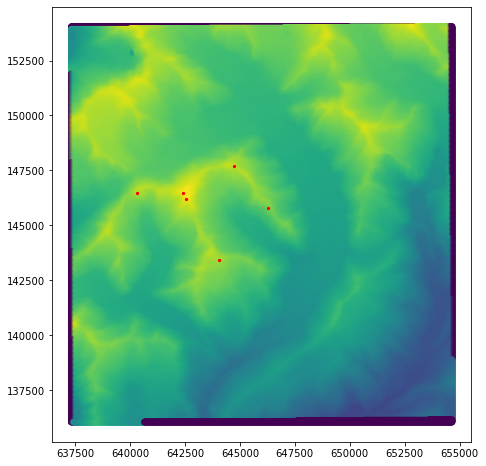

In [68]:
fig = plt.figure(figsize = (12, 8))
plt.scatter(points[:,0],points[:,1], c=points[:,2])
plt.scatter(Geo_Keypoints[highestElev_index][:,0], Geo_Keypoints[highestElev_index][:,1], c='red', s=5)
plt.axis('scaled')
plt.show()

In [37]:
# np.savetxt('Geo_Keypoints_no_deletion.out', Geo_Keypoints, delimiter=',')